# Classification from the masks

In [1]:
import os
import random
from tqdm import tqdm

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, array_to_img, img_to_array

from skimage.io import imshow
import matplotlib.pyplot as plt 

from custom_functions import dice_coef, IoU_coeff, IoULoss, DiceLoss, intersection


## Images loading and preprocessing

In [2]:
IMG_WIDTH_HEIGHT = 256
IMG_CHANNELS = 3
classes = 1

In [3]:
path = "data/"
input_dir = path + 'images/'
target_dir = path + 'masks/'

In [4]:
input_img_paths = sorted(
    [
        fname
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        fname
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

In [5]:
len(input_img_paths)

1997

In [6]:
N = len(input_img_paths)
X = []
Y = []

for i in tqdm(range(N)):
    img_path = input_img_paths[i]
    if os.path.isfile(input_dir + img_path) and os.path.isfile(target_dir + img_path):
        img = load_img(input_dir + img_path, grayscale=False,target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) 
        img = img_to_array(img)
        X.append(img.astype('float32') / 255.0)

        #mask_path = target_img_paths[i]
        mask = load_img(target_dir + img_path, color_mode = "grayscale",target_size=(IMG_WIDTH_HEIGHT, IMG_WIDTH_HEIGHT)) 
        mask = img_to_array(mask)
        Y.append(mask // 200)
        
X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.uint8)

100%|██████████| 1997/1997 [00:22<00:00, 89.64it/s] 


## Separation of images with and without silos

In [7]:
def with_silos(mask_array):
    return np.sum(mask_array, axis=(0, 1, 2))>10

In [8]:
X_silos = []
Y_silos = []

X_no_silos = []
Y_no_silos = []

for i in range(len(Y)):
    if with_silos(Y[i]):
        Y_silos.append(Y[i])
        X_silos.append(X[i])
    else:
        X_no_silos.append(X[i])
        Y_no_silos.append(Y[i])
        
X_silos = np.array(X_silos, dtype=np.float32)
Y_silos = np.array(Y_silos, dtype=int)

X_no_silos = np.array(X_no_silos, dtype=np.float32)
Y_no_silos = np.array(Y_no_silos, dtype=int)

## Generation of the train and test set of the segmentation model

In [38]:
split_silos = int(len(X_silos)*0.8)

X_train = X_silos[:split_silos] # Segmentation model has been trained only on those images
Y_train = Y_silos[:split_silos]

X_test = X_silos[split_silos:]
Y_test = Y_silos[split_silos:]

In [10]:
len(X_train)

439

## Naive classification from the masks

In [23]:
MODEL_PATH = "unet_silos3.hdf5"
model = keras.models.load_model(MODEL_PATH, custom_objects={'IoU_coeff': IoU_coeff, 'dice_coef': dice_coef, 'DiceLoss':  DiceLoss})

In [24]:
i = 46
THRESHOLD = 0.6
silos = 0
predictions = model.predict(X_no_silos)
for i in range(len(X_no_silos)):
    silos += np.sum(np.array(predictions[i]>THRESHOLD, dtype=np.uint8), axis=(0, 1, 2))>100
print(f"There are {silos} detected silos on {len(X_no_silos)} images without silos")

silos = 0
predictions = model.predict(X_test)
for i in range(len(X_test)):
    silos += np.sum(np.array(predictions[i]>THRESHOLD, dtype=np.uint8), axis=(0, 1, 2))>100
    

print(f"There are {silos} dectected silos on {len(X_test)} images with silos")

There are 13 detected silos on 930 images without silos
There are 105 dectected silos on 110 images with silos


In [25]:
def n_silos_detected(X, predictions, threshold, limit):
    silos = 0
    for i in range(len(X)):
        silos += np.sum(np.array(predictions[i] > threshold, dtype=np.uint8), axis=(0, 1, 2)) >= limit
    return silos

In [26]:
def accuracy(X_test, X_no_silos, pred_test, pred_no_silos):
    thresholds = np.linspace(0, 1, 40)
    
    acc_test = []
    acc_sans = []
    auc = []
    for threshold in thresholds:
        acc_test.append((n_silos_detected(X_test, pred_test, threshold, 10)) / len(X_test))
        acc_sans.append((len(X_no_silos) - n_silos_detected(X_no_silos, pred_sans, threshold, 10)) / len(X_no_silos))
        auc.append((n_silos_detected(X_test, pred_test, threshold, 10) + len(X_sans) - n_silos_detected(X_sans, pred_sans, threshold, 10))/(len(X_test) + len(X_sans)))
    plt.plot(thresholds, acc_test)
    plt.plot(thresholds, acc_sans)
    plt.plot(thresholds, auc)
    plt.show()

In [33]:
def roc_curve(X_test, X_no_silos, pred_test, pred_no_silos):
    thresholds = [0, 5, 10, 20, 50, 80, 100, 200, 300, 400, 500, 600, 700, 800, 1000, 5000]
    
    TPR = []
    FPR = []
    for threshold in thresholds:
        n_test = n_silos_detected(X_test, pred_test, 0.6, threshold)
        n_sans = n_silos_detected(X_no_silos, pred_sans, 0.6, threshold)
        TPR.append(n_test / len(X_test))
        FPR.append(n_sans / len(X_no_silos))
    plt.plot(FPR, TPR)
    plt.show()
    print(f"The calculated AUC is : {round(np.trapz(y=sorted(TPR), x=sorted(FPR)), 3)}")

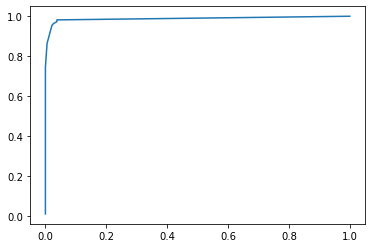

The calculated AUC is : 0.988


In [34]:
X_sans = X_no_silos[:int(len(X_no_silos)*0.2)]
pred_test = model.predict(X_test)
pred_sans = model.predict(X_sans)
roc_curve(X_test, X_sans, pred_test, pred_sans)

## Classification with a CNN on the masks

In [35]:
!pip install opencv-python
import cv2
import math
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [43]:
MODEL_PATH = "unet_silos3.hdf5"
segmentation_model = keras.models.load_model(MODEL_PATH, custom_objects={'IoU_coeff': IoU_coeff, 'dice_coef': dice_coef, 'DiceLoss':  DiceLoss})

In [37]:
print(len(X_no_silos))
print(len(X_train))
print(len(X_test))

930
439
110


## Prediction of the masks on the training and the test set

In [41]:
# Creation of the train and the test set
limit = int(len(X_no_silos)*0.8)
img_train = np.append(X_train, X_no_silos[:limit], axis=0)
y_train = np.append(np.ones(len(X_train)), np.zeros(limit))

img_test = np.append(X_test, X_no_silos[limit:], axis=0)
y_test = np.append(np.ones(len(X_test)), np.zeros(len(X_no_silos[limit:])))

In [44]:
mask_train = segmentation_model.predict(img_train)
mask_test = segmentation_model.predict(img_test)

## Classification model

In [52]:
model_c = Sequential(name = 'Salinas_CNN')

model_c.add(layers.Rescaling(1./255, input_shape=(256, 256, 1)))
model_c.add(Conv2D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer2'))
model_c.add(Conv2D(filters = 64, kernel_size = 3, activation ='relu' , name = 'Layer3'))

model_c.add(MaxPooling2D(pool_size = 2, name = 'MaxPooling_Layer1'))
model_c.add(Dropout(0.4, name = 'Dropout1'))

model_c.add(Conv2D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer4'))
model_c.add(Conv2D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer5'))
model_c.add(Conv2D(filters = 32, kernel_size = 3, activation ='relu', name = 'Layer6'))

model_c.add(MaxPooling2D(pool_size = 2, name = 'MaxPooling_Layer2'))
model_c.add(Dropout(0.4, name = 'Dropout2'))

model_c.add(Flatten(name = 'Flatten'))

model_c.add(Dense(512, activation='relu', name = 'DenseLayer1'))

model_c.add(Dropout(0.5, name = 'Dropout3'))

model_c.add(Dense(1, activation='sigmoid', name = 'DenseLayer2'))

In [53]:
model_c.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4), 
                loss = 'binary_crossentropy',
                metrics = [AUC()])

earlystopper = EarlyStopping(monitor="val_loss",
                             mode="min", 
                             verbose= 1,
                             patience=12,
                             restore_best_weights=True)

hist_C = model_c.fit(mask_train, y_train, 
                     validation_data = [mask_test, y_test],
                     epochs = 40, 
                     batch_size = 16,
                     callbacks=[earlystopper])

Epoch 1/40
74/74 [==============================] - 5s 55ms/step - loss: 0.6663 - auc_2: 0.4948 - val_loss: 0.6712 - val_auc_2: 0.5045
Epoch 2/40
74/74 [==============================] - 3s 47ms/step - loss: 0.6656 - auc_2: 0.4889 - val_loss: 0.6608 - val_auc_2: 0.5045
Epoch 3/40
74/74 [==============================] - 3s 40ms/step - loss: 0.6625 - auc_2: 0.4975 - val_loss: 0.6613 - val_auc_2: 0.5227
Epoch 4/40
74/74 [==============================] - 3s 45ms/step - loss: 0.6623 - auc_2: 0.5005 - val_loss: 0.6595 - val_auc_2: 0.7000
Epoch 5/40
74/74 [==============================] - 3s 46ms/step - loss: 0.6596 - auc_2: 0.5355 - val_loss: 0.6546 - val_auc_2: 0.9766
Epoch 6/40
74/74 [==============================] - 3s 45ms/step - loss: 0.6456 - auc_2: 0.6125 - val_loss: 0.6309 - val_auc_2: 0.9487
Epoch 7/40
74/74 [==============================] - 3s 46ms/step - loss: 0.5786 - auc_2: 0.7856 - val_loss: 0.5052 - val_auc_2: 0.9845
Epoch 8/40
74/74 [==============================] - 3s 

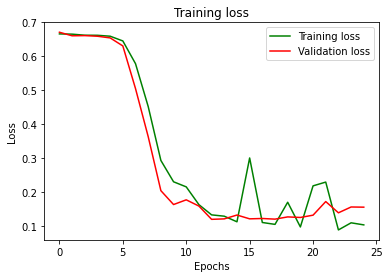

In [54]:
plt.plot(hist_C.epoch, hist_C.history["loss"], 'g', label='Training loss')
plt.plot(hist_C.epoch, hist_C.history["val_loss"], 'r', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

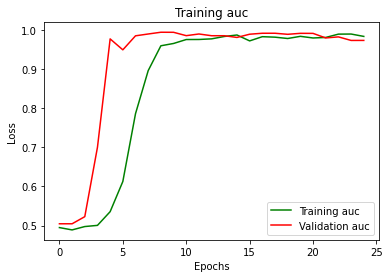

In [57]:
plt.plot(hist_C.epoch, hist_C.history["auc_2"], 'g', label='Training auc')
plt.plot(hist_C.epoch, hist_C.history["val_auc_2"], 'r', label='Validation auc')
plt.title('Training auc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [58]:
model_c.evaluate(mask_test, y_test, batch_size=16)

19/19 [==============================] - 0s 13ms/step - loss: 0.1198 - auc_2: 0.9847


[0.11982036381959915, 0.9847263097763062]

In [ ]:
model_c.save("model_classif_v1")